In [1]:
import sys, os, json, numpy as np
from pathlib import Path
sys.path.insert(1, str(Path.home()) + '/.xacc')
import xacc
import csv
import time
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# This script is used to calibrate CR pulses 
# Based on "Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses"
# Two transmon qubits are modeled as three-level systems:
# Qubit freq. and anharmonicity data is from the paper.
# Qubit-Qubit coupling (J) is provided by fitting data.
hamiltonianJson = {
    "description": "Two-qutrit Hamiltonian",
    "h_latex": "",
    "h_str": ["_SUM[i,0,1,wq{i}*O{i}]", "_SUM[i,0,1,delta{i}*O{i}*(O{i}-I{i})]", "_SUM[i,0,1,omegad{i}*X{i}||D{i}]", "omegad1*X0||U0", "omegad0*X1||U1", "jq0q1*Sp0*Sm1", "jq0q1*Sm0*Sp1"],
    "osc": {},
    "qub": {
        "0": 2,
        "1": 2
    },
    "vars": {
        "wq0": 30.518812656662774, 
        "wq1": 31.238229295532093,
        "delta0": -2.011875935,
        "delta1": -2.008734343,
        "omegad0": -1.703999855,
        "omegad1": -1.703999855,
        "jq0q1": 0.011749557 
    }
}

# Calibration Procedure:
## 1. Find CR pulse amplitude to implement ~ZX(pi/2)
Start with initial |00> state, sweep CR amplitude to find the one that make target qubit ~ X(pi/2) 

i.e. excited state population = 0.5; exp-Z = 0

Results: Amplitudes of the CR pulses are: CR_01: 0.47307243770437246 and CR_10: 0.47568434330188614

## 2. Find pre- and post- U3 correction to eliminate local rotation
Use QPT (target = CNOT) as the cost function, optimize for the 12 parameters:
i.e. U3_pre(a,b,c) and U3_post(x,y,z) on both Q0 and Q1 (6 params per qubit)

In [ ]:
def runSim(ampl, control, target):
    # Create a pulse system model object 
    model = xacc.createPulseModel()

    # Load the Hamiltonian JSON (string) to the system model
    loadResult = model.loadHamiltonianJson(json.dumps(hamiltonianJson))

    if loadResult is True :
        qpu = xacc.getAccelerator('QuaC', {'system-model': model.name(), 'shots': 1024 })        
        # CR drive length = 848*dt
        nSamples = 848
        channelConfigs = xacc.BackendChannelConfigs()
        channelConfigs.dt = 0.222
       
        channelConfigs.loFregs_dChannels = [4.857, 4.972]   
        channelConfigs.loFregs_uChannels = [4.972, 4.857]   
        # Amplitude
        A = ampl
        pulse_name = 'square' + str(ampl)
        channelConfigs.addOrReplacePulse(pulse_name, xacc.GaussianSquare(nSamples, A, 32, 720))
        model.setChannelConfigs(channelConfigs)
        
        provider = xacc.getIRProvider('quantum')
        composite = provider.createComposite('test_pulse')
        channel = 'u' + str(control)
        pulse = xacc.createPulse(pulse_name, channel)
        composite.addInstruction(pulse)
        qubitReg = xacc.qalloc(2)
        qpu.execute(qubitReg, composite)
        print(qubitReg)
        return qubitReg['<O>'][target]

In [ ]:
optimizer = xacc.getOptimizer('nlopt', {'initial-parameters': [1.0]})
# Optimize CR_0_1
def opt_func_0(x):
    ampl = x[0]
    print(ampl)
    return abs(0.5 - runSim(ampl, 0, 1))
opt_val, opt_params = optimizer.optimize(opt_func_0, 1)
print("CR_0_1")
print(opt_val)
print(opt_params)

In [ ]:
optimizer = xacc.getOptimizer('nlopt', {'initial-parameters': [1.0]})
# Optimize CR_1_0
def opt_func_1(x):
    ampl = x[0]
    print(ampl)
    return abs(0.5 - runSim(ampl, 1, 0))
opt_val, opt_params = optimizer.optimize(opt_func_1, 1)
print("CR_1_0")
print(opt_val)
print(opt_params)

## Verify CR_01 (control = Q0)

The population of Q1 (target qubit) is 0.5 (i.e., equivalent to X^(1/2))

In [5]:
# Verify the pulse amplitude:

# Create a pulse system model object 
model = xacc.createPulseModel()

# Load the Hamiltonian JSON (string) to the system model
loadResult = model.loadHamiltonianJson(json.dumps(hamiltonianJson))

if loadResult is True :
    qpu = xacc.getAccelerator('QuaC', {'system-model': model.name(), 'shots': 1024, 'logging-period': 0.1 })        
    # CR drive length = 848*dt
    nSamples = 848
    channelConfigs = xacc.BackendChannelConfigs()
    channelConfigs.dt = 0.222

    channelConfigs.loFregs_dChannels = [4.857, 4.972]   
    channelConfigs.loFregs_uChannels = [4.972, 4.857]   
    # Amplitude
    # CR_01: 0.47307243770437246 
    A = 0.47307243770437246
    pulse_name = 'square' + str(A)
    channelConfigs.addOrReplacePulse(pulse_name, xacc.GaussianSquare(nSamples, A, 32, 720))
    model.setChannelConfigs(channelConfigs)

    provider = xacc.getIRProvider('quantum')
    composite = provider.createComposite('test_pulse')
    channel = 'u0'
    pulse = xacc.createPulse(pulse_name, channel)
    composite.addInstruction(pulse)
    qubitReg = xacc.qalloc(2)
    qpu.execute(qubitReg, composite)
    print(qubitReg)
    # Get the CSV file name and data
    csvFile1 = qubitReg['csvFile']
    data1 = np.genfromtxt(csvFile1, delimiter = ',', dtype=float, names=True)

{
    "AcceleratorBuffer": {
        "name": "                     \"__main__\", mod_spec)\n",
        "size": 2,
        "Information": {
            "<O>": [
                0.008658198111676938,
                0.49999864126916668
            ],
            "DensityMatrixDiags": [
                0.49395113113935337,
                0.49739067074897189,
                0.006050227591482156,
                0.0026079705201947818
            ],
            "csvFile": "/Users/7tn/dev/QuaC/xacc_examples/python/output_20200427_09:37:11.csv"
        },
        "Measurements": {}
    }
}


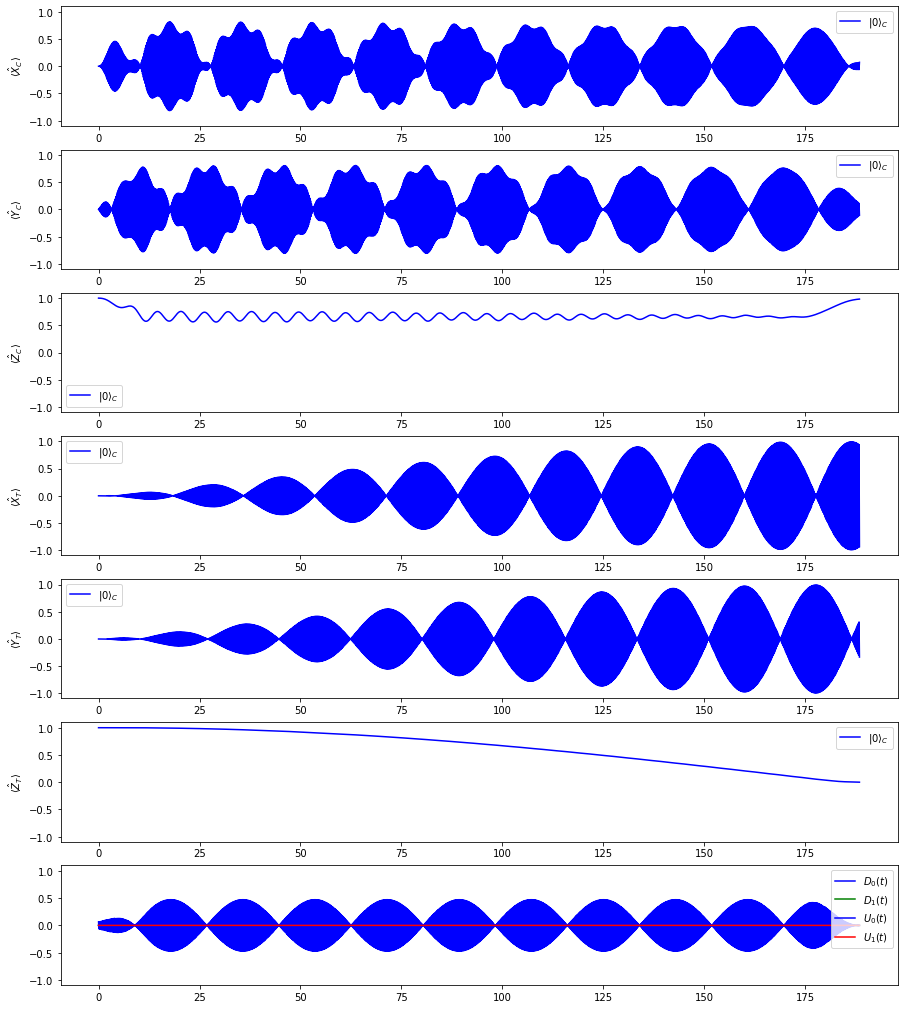

In [6]:
# Control qubit: Q0
fig, ax = plt.subplots(7,1,sharey=True,figsize=(15,18))
ax[0].plot(data1['Time'], data1['X0'], 'b', label = '$|0\\rangle_C$')
ax[1].plot(data1['Time'], data1['Y0'], 'b', label = '$|0\\rangle_C$')
ax[2].plot(data1['Time'], data1['Z0'], 'b', label = '$|0\\rangle_C$')
ax[0].set_ylabel('$\\langle \hat{X}_C \\rangle$')
ax[1].set_ylabel('$\\langle \hat{Y}_C \\rangle$')
ax[2].set_ylabel('$\\langle \hat{Z}_C \\rangle$')

# Target qubit: Q1
ax[3].plot(data1['Time'], data1['X1'], 'b', label = '$|0\\rangle_C$')
ax[4].plot(data1['Time'], data1['Y1'], 'b', label = '$|0\\rangle_C$')
ax[5].plot(data1['Time'], data1['Z1'], 'b', label = '$|0\\rangle_C$')
ax[3].set_ylabel('$\\langle \hat{X}_T \\rangle$')
ax[4].set_ylabel('$\\langle \hat{Y}_T \\rangle$')
ax[5].set_ylabel('$\\langle \hat{Z}_T \\rangle$')
ax[5].set_xlabel('Time ($10^{-10}s$)')

# Channels:
ax[6].plot(data1['Time'], data1['Channel0'], 'b', label = '$D_0(t)$')
ax[6].plot(data1['Time'], data1['Channel1'], 'g', label = '$D_1(t)$')
ax[6].plot(data1['Time'], data1['Channel2'], 'b', label = '$U_0(t)$')
ax[6].plot(data1['Time'], data1['Channel3'], 'r', label = '$U_1(t)$')


for i in range(7): 
    ax[i].legend()

## Verify CR_10 (control = Q1)

The population of Q0 (target qubit) is 0.5 (i.e., equivalent to X^(1/2))

In [8]:
# Verify the pulse amplitude:

# Create a pulse system model object 
model = xacc.createPulseModel()

# Load the Hamiltonian JSON (string) to the system model
loadResult = model.loadHamiltonianJson(json.dumps(hamiltonianJson))

if loadResult is True :
    qpu = xacc.getAccelerator('QuaC', {'system-model': model.name(), 'shots': 1024, 'logging-period': 0.1 })        
    # CR drive length = 848*dt
    nSamples = 848
    channelConfigs = xacc.BackendChannelConfigs()
    channelConfigs.dt = 0.222

    channelConfigs.loFregs_dChannels = [4.857, 4.972]   
    channelConfigs.loFregs_uChannels = [4.972, 4.857]   
    # Amplitude
    # CR_10: 0.47568434330188614
    A = 0.47568434330188614
    pulse_name = 'square' + str(A)
    channelConfigs.addOrReplacePulse(pulse_name, xacc.GaussianSquare(nSamples, A, 32, 720))
    model.setChannelConfigs(channelConfigs)

    provider = xacc.getIRProvider('quantum')
    composite = provider.createComposite('test_pulse')
    channel = 'u1'
    pulse = xacc.createPulse(pulse_name, channel)
    composite.addInstruction(pulse)
    qubitReg = xacc.qalloc(2)
    qpu.execute(qubitReg, composite)
    print(qubitReg)
    # Get the CSV file name and data
    csvFile1 = qubitReg['csvFile']
    data1 = np.genfromtxt(csvFile1, delimiter = ',', dtype=float, names=True)

{
    "AcceleratorBuffer": {
        "name": "                     \"__main__\", mod_spec)\n00",
        "size": 2,
        "Information": {
            "<O>": [
                0.4999999704418932,
                0.007413119059152673
            ],
            "DensityMatrixDiags": [
                0.493287609189689,
                0.006712420368417318,
                0.49929927175115787,
                0.0007006986907353553
            ],
            "csvFile": "/Users/7tn/dev/QuaC/xacc_examples/python/output_20200427_09:42:42.csv"
        },
        "Measurements": {}
    }
}


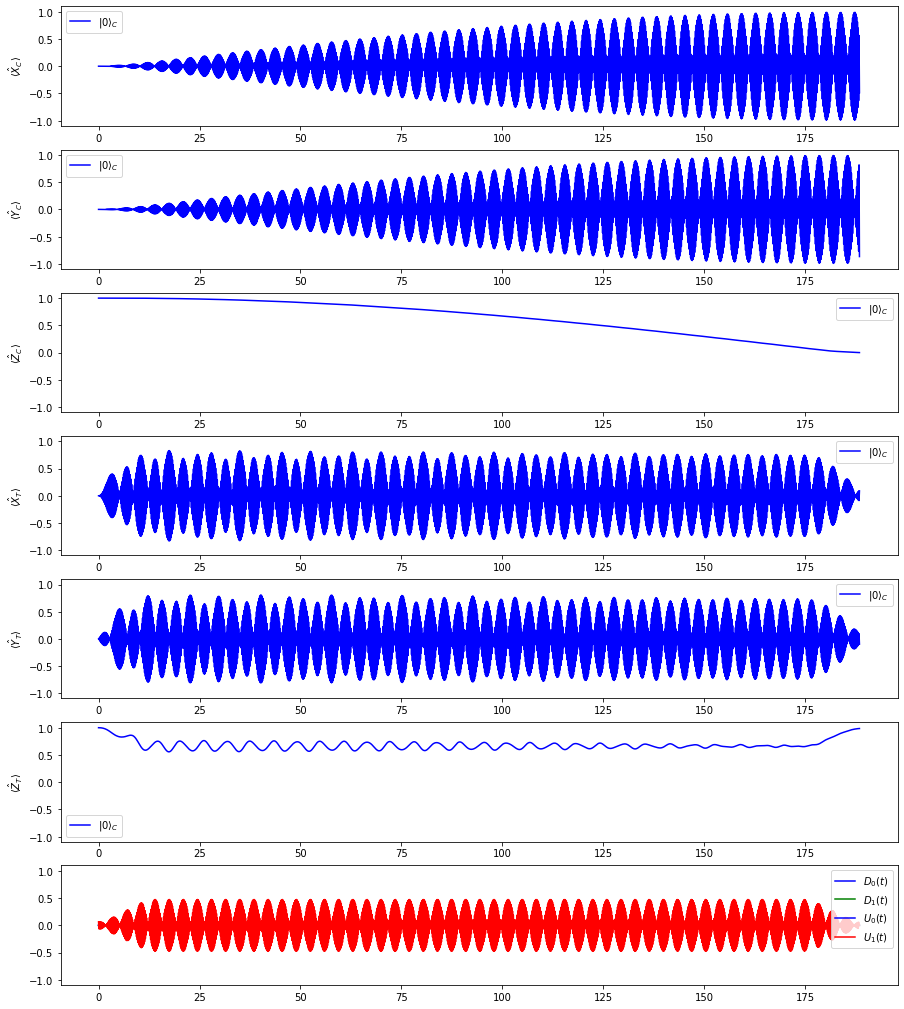

In [9]:
# Target qubit: Q0
fig, ax = plt.subplots(7,1,sharey=True,figsize=(15,18))
ax[0].plot(data1['Time'], data1['X0'], 'b', label = '$|0\\rangle_C$')
ax[1].plot(data1['Time'], data1['Y0'], 'b', label = '$|0\\rangle_C$')
ax[2].plot(data1['Time'], data1['Z0'], 'b', label = '$|0\\rangle_C$')
ax[0].set_ylabel('$\\langle \hat{X}_C \\rangle$')
ax[1].set_ylabel('$\\langle \hat{Y}_C \\rangle$')
ax[2].set_ylabel('$\\langle \hat{Z}_C \\rangle$')

# Control qubit: Q1
ax[3].plot(data1['Time'], data1['X1'], 'b', label = '$|0\\rangle_C$')
ax[4].plot(data1['Time'], data1['Y1'], 'b', label = '$|0\\rangle_C$')
ax[5].plot(data1['Time'], data1['Z1'], 'b', label = '$|0\\rangle_C$')
ax[3].set_ylabel('$\\langle \hat{X}_T \\rangle$')
ax[4].set_ylabel('$\\langle \hat{Y}_T \\rangle$')
ax[5].set_ylabel('$\\langle \hat{Z}_T \\rangle$')
ax[5].set_xlabel('Time ($10^{-10}s$)')

# Channels:
ax[6].plot(data1['Time'], data1['Channel0'], 'b', label = '$D_0(t)$')
ax[6].plot(data1['Time'], data1['Channel1'], 'g', label = '$D_1(t)$')
ax[6].plot(data1['Time'], data1['Channel2'], 'b', label = '$U_0(t)$')
ax[6].plot(data1['Time'], data1['Channel3'], 'r', label = '$U_1(t)$')


for i in range(7): 
    ax[i].legend()

## Pre- and Post- CR Correction

We add U3 gates in both qubit lines (control and target) before and after the CR pulses.

There are thus 4 U3 gates with 12 parameters. The optimizer then optimize these params to achieve CNOT QPT.

In [ ]:
# Create a pulse system model object 
model = xacc.createPulseModel()

# Load the Hamiltonian JSON (string) to the system model
loadResult = model.loadHamiltonianJson(json.dumps(hamiltonianJson))

if loadResult is True :
    qpu = xacc.getAccelerator('QuaC', {'system-model': model.name(), 'shots': 1024 })        
    # CR drive length = 848*dt
    nSamples = 848
    channelConfigs = xacc.BackendChannelConfigs()
    channelConfigs.dt = 0.222

    channelConfigs.loFregs_dChannels = [4.857, 4.972]   
    channelConfigs.loFregs_uChannels = [4.972, 4.857]   
    # Amplitude
    # CR_01: 0.47307243770437246 
    A = 0.47307243770437246
    pulse_name = 'square' + str(A)
    channelConfigs.addOrReplacePulse(pulse_name, xacc.GaussianSquare(nSamples, A, 32, 720))
    model.setChannelConfigs(channelConfigs)

    provider = xacc.getIRProvider('quantum')
    composite = provider.createComposite('test_pulse')
    channel = 'u0'
    pulse = xacc.createPulse(pulse_name, channel)
    composite.addInstruction(pulse)
    qubitReg = xacc.qalloc(2)
    
    # Get Quantum Process Tomography Algo
    qpt = xacc.getAlgorithm('qpt')
    qpt.initialize({'circuit': composite, 'accelerator': qpu, 'optimize-circuit': False})
    qpt.execute(qubitReg)
    qpp_chi_real_vec = qppReg["chi-real"]
    qpp_chi_imag_vec = qppReg["chi-imag"]